# Data Gather

### **library imports**

In [99]:
import cv2
import mediapipe as mp
import numpy as np
import csv
from scipy.signal import butter, filtfilt
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
import pandas as pd
import matplotlib.pyplot as plt
import os  # Add import for os module
from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

### **Initialize MediaPipe Pose**

In [100]:
'''This script uses MediaPipe to process video frames for pose estimation.'''
mp_pose = mp.solutions.pose  # Access MediaPipe's pose solution
mp_drawing = mp.solutions.drawing_utils  # Utility for drawing landmarks on frames
pose = mp_pose.Pose(
    static_image_mode=False,  # Process video frames in a continuous stream
    min_detection_confidence=0.5,  # Minimum confidence for detecting landmarks
    min_tracking_confidence=0.5  # Minimum confidence for tracking landmarks
)

### **Function to calculate the angle between two points in the XOY plane**

In [101]:
def angle_from_origin_xoy(p1, p2):
    '''Calculate the angle between two points in the XOY plane.
    Args:
        p1 (tuple): Coordinates of the first point (x1, y1).
        p2 (tuple): Coordinates of the second point (x2, y2).
        Returns:
        float: The angle in degrees between the line connecting the two points and the x-axis.'''
    delta_x = p2[0] - p1[0]
    delta_y = p1[1] - p2[1]  # Invert y-axis for Cartesian coordinates
                
    if delta_x == 0 and delta_y == 0:
        return 0.0  # Handle identical points
                
    angle = np.degrees(np.arctan2(delta_y, delta_x))
    angle = abs(angle)  # Convert -180 to -90 to 90 to 180
    if angle > 90:  # Second and third quadrants
        angle = 180 - angle  # Map 90-180 to 90-0            
    return angle

In [102]:
def draw_angles(frame, origin, target, angle,label):
    # geometry
    cv2.circle(frame, origin, 8, (0,255,0),   -1)
    cv2.circle(frame, target, 8, (0,0,255),   -1)
    cv2.line(  frame, origin, target, (255,255,0), 2)

    # Display metrics text
    x_txt, y_txt = target[0] + 10, max(target[1] - 10, 20)
    cv2.putText(frame, f"{label}: {angle:.1f}", (x_txt, y_txt),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 255), 2)  # Yellow text

In [103]:
def butter_lowpass_filter(data, cutoff=0.2, order=4):
        b, a = butter(order, cutoff, btype='low', analog=False)
        return filtfilt(b, a, data)

In [104]:
scaler = MinMaxScaler()

### **Function to process video and calculate angles**

In [105]:
from typing import Dict

def process_video_and_calculate_angles(video_path, landmarks: Dict[str,int], classification_class):
    # Initialize an empty DataFrame with VideoName column
    columns = ["Frame", "Time"]
    for landmark_name in landmarks.keys():
        columns.extend([
            f"{landmark_name}_Angle",
            f"{landmark_name}_Velocity",
            f"{landmark_name}_Acceleration"
        ])
    angles_processed_data = pd.DataFrame(columns=columns)

    temporal_data = pd.DataFrame(columns=columns)  # Initialize temporal_data separately

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error opening video.")
        return

    fps = int(cap.get(cv2.CAP_PROP_FPS))
    scale = (1000, 800)
    frame_atual = 1

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret or frame is None:
            print("End of video or cannot read the frame.")
            break
        
        print(f"Processing video: {video_path}")
        imagem_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        resultado = pose.process(imagem_rgb)

        if resultado.pose_landmarks:
            mp_drawing.draw_landmarks(frame, resultado.pose_landmarks, mp_pose.POSE_CONNECTIONS)

            # Get reference point (midpoint between hips)
            left_hip = resultado.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_HIP]
            right_hip = resultado.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_HIP]
            ref_x = (left_hip.x + right_hip.x) / 2
            ref_y = (left_hip.y + right_hip.y) / 2

            row_data = {
                    "Frame": frame_atual,
                    "Time": frame_atual / fps
            }

            for landmark_name, landmark_to_compare in landmarks.items():
                # Use the index directly to get the specified landmark
                target_landmark = resultado.pose_landmarks.landmark[int(landmark_to_compare)]

                # Convert normalized coordinates to image coordinates
                h, w, _ = frame.shape
                ref_pt = (int(ref_x * w), int(ref_y * h))
                target_pt = (int(target_landmark.x * w), int(target_landmark.y * h))

                # Calculate angle
                angulo = angle_from_origin_xoy(ref_pt, target_pt)

                if angulo is not None:
                    print(f"Frame {frame_atual}: {landmark_name} angle: {angulo:.2f} degrees")
                    draw_angles(frame, ref_pt, target_pt, angulo,landmark_name)                    
                    
                    # Add angle to row_data
                    row_data[f"{landmark_name}_Angle"] = angulo
                else:
                    print(f"Frame {frame_atual}: Unable to calculate angle.")

            # After processing all landmarks for this frame, append row_data to temporal_data
            temporal_data = pd.concat([temporal_data, pd.DataFrame([row_data])], ignore_index=True)
                
            
            if not angles_processed_data.empty:
                for landmark_name in landmarks.keys():
                    velocity_col = f"{landmark_name}_Velocity"
                    acceleration_col = f"{landmark_name}_Acceleration"
                    last_velocity = angles_processed_data[velocity_col].dropna().iloc[-1] 
                    last_acceleration = angles_processed_data[acceleration_col].dropna().iloc[-1] 
                    
                                # Improved text formatting with consistent dynamic positioning
                y_offset = 30  # Initial vertical offset
                x_offset = 10  # Horizontal offset for text placement

                for i, landmark_name in enumerate(landmarks.keys()):
                    velocity_col = f"{landmark_name}_Velocity"
                    acceleration_col = f"{landmark_name}_Acceleration"
                    
                    # Check if data is valid
                    if not angles_processed_data[velocity_col].dropna().empty and not angles_processed_data[acceleration_col].dropna().empty:
                        last_velocity = angles_processed_data[velocity_col].dropna().iloc[-1]
                        last_acceleration = angles_processed_data[acceleration_col].dropna().iloc[-1]
                        
                        # Format text
                        text = f"{landmark_name} - Velocity: {last_velocity:.2f} / Acceleration: {last_acceleration:.2f}"
                        
                        # Adjust position dynamically
                        cv2.putText(frame, text, (x_offset, y_offset), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2, cv2.LINE_AA)
                        
                        # Increment vertical offset for the next annotation
                        y_offset += 30  # Ensure enough spacing between annotations
                        
                        
            # Every second, append data to angles_processed_data and clear temporal_data
            if (frame_atual) % fps == 0:
                # Calculate velocity and acceleration for each landmark angle
                for landmark_name in landmarks.keys():
                    angle_col = f"{landmark_name}_Angle"
                    velocity_col = f"{landmark_name}_Velocity"
                    acceleration_col = f"{landmark_name}_Acceleration"
                    
                    # Apply Butterworth lowpass filter to smooth the angle data
                    temporal_data[f"{angle_col}_filtered"] = butter_lowpass_filter(
                        temporal_data[angle_col].astype(float))
                    
                    # Calculate velocity and acceleration
                    temporal_data[velocity_col] = np.gradient(temporal_data[angle_col], temporal_data["Frame"])
                    temporal_data[acceleration_col] = np.gradient(temporal_data[velocity_col], temporal_data["Frame"])
                    
                    # Normalize velocity and acceleration for each landmark
                    cols_to_normalize = [velocity_col, acceleration_col]
                    temporal_data[[f"{velocity_col}_normalized", f"{acceleration_col}_normalized"]] = scaler.fit_transform(
                        temporal_data[cols_to_normalize]
                    )
                print(f"Processed angles for frame {frame_atual}:")
                print(angles_processed_data.head())
                angles_processed_data = pd.concat([angles_processed_data,temporal_data], ignore_index=True)
                temporal_data = temporal_data.iloc[0:0]  # Clear the DataFrame for the next batch                        
                    

        frame_resized = cv2.resize(frame, scale)
        cv2.imshow("Angle Visualization", frame_resized)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

        frame_atual += 1
        
    cap.release()
    cv2.destroyAllWindows()
    
    angles_processed_data["Classification"] = classification_class
    angles_processed_data["Video Name"] = os.path.basename(video_path)  # Add video name to DataFrame
    
    return angles_processed_data


### **Function to join second data**

In [106]:
import pandas as pd

def reshape_dataframe(df, frames_per_group=30):
    """
    Groups by 'Video Name' and each 30-frame segment, then averages stats.
    """
    # Create a group index for every 30 frames
    df = df.copy()
    df['Seconds'] = (df['Frame'] // frames_per_group).astype(int)
    
    # Columns to aggregate (numeric only, excluding Frame and Frame_Group)
    numeric_cols = df.select_dtypes(include='number').columns.difference(['Frame', 'Seconds', "Time"])
    
    # Group by Video Name and Frame_Group, aggregate by mean
    grouped = df.groupby(['Video Name', 'Seconds'])
    agg_df = grouped[numeric_cols].mean().reset_index()
    
    # Get the first Classification for each group
    agg_df['Classification'] = grouped['Classification'].first().values
    agg_df['Video Name'] = grouped['Video Name'].first().values
    
    return agg_df

### **Define the landmarks of interest**

In [107]:
landmarks_ids = {
    "head": 0,  # Head (nose landmark)
    "left_wrist": 15,  # Left wrist
    "right_wrist": 16,  # Right wrist
    "left_ankle": 27,  # Left ankle
    "right_ankle": 28  # Right ankle
}
print("Landmarks de interesse definidos:", landmarks_ids)


Landmarks de interesse definidos: {'head': 0, 'left_wrist': 15, 'right_wrist': 16, 'left_ankle': 27, 'right_ankle': 28}


### **Gather data from videos**

In [108]:
videos_folder = '.\\Videos\\'
data_folder = '.\\Data\\'
videos = {
    'direct.MOV': 'direct',
    'impro_free.MP4': 'direct',    
    'indirect(cut).mp4': 'indirect',
    'Phrase3.mp4': 'indirect',
    'sustained (direct).MOV': 'direct',
    'sustained (indirect).MOV': 'indirect',
}

def get_videos_data(videos, landmarks, videos_folder):
    all_data = pd.DataFrame()
    for video, classification in videos.items():
        landmark_processed_data = process_video_and_calculate_angles(
            os.path.join(videos_folder, video), landmarks, classification)
        all_data = pd.concat([all_data, landmark_processed_data], ignore_index=True)
    return all_data

landmark_processed_data = get_videos_data(videos, landmarks_ids, videos_folder)
landmark_processed_data.to_csv(os.path.join(data_folder, 'landmark_processed_data.csv'), index=False)

# Usage
landmark_processed_data = reshape_dataframe(landmark_processed_data)
landmark_processed_data.head(50)
landmark_processed_data.to_csv(os.path.join(data_folder, 'landmark_processed_data_reshaped.csv'), index=False)

Processing video: .\Videos\direct.MOV
Frame 1: head angle: 86.16 degrees
Frame 1: left_wrist angle: 15.14 degrees
Frame 1: right_wrist angle: 8.38 degrees
Frame 1: left_ankle angle: 76.66 degrees
Frame 1: right_ankle angle: 80.07 degrees
Processing video: .\Videos\direct.MOV
Frame 2: head angle: 86.30 degrees
Frame 2: left_wrist angle: 18.91 degrees
Frame 2: right_wrist angle: 8.75 degrees
Frame 2: left_ankle angle: 76.71 degrees
Frame 2: right_ankle angle: 79.89 degrees
Processing video: .\Videos\direct.MOV
Frame 3: head angle: 86.29 degrees
Frame 3: left_wrist angle: 21.94 degrees
Frame 3: right_wrist angle: 6.77 degrees
Frame 3: left_ankle angle: 76.64 degrees
Frame 3: right_ankle angle: 79.65 degrees


C:\Users\asus\AppData\Local\Temp\ipykernel_15316\3771154861.py:71: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  temporal_data = pd.concat([temporal_data, pd.DataFrame([row_data])], ignore_index=True)


Processing video: .\Videos\direct.MOV
Frame 4: head angle: 86.39 degrees
Frame 4: left_wrist angle: 32.22 degrees
Frame 4: right_wrist angle: 0.43 degrees
Frame 4: left_ankle angle: 76.64 degrees
Frame 4: right_ankle angle: 79.60 degrees
Processing video: .\Videos\direct.MOV
Frame 5: head angle: 86.49 degrees
Frame 5: left_wrist angle: 9.46 degrees
Frame 5: right_wrist angle: 6.76 degrees
Frame 5: left_ankle angle: 76.34 degrees
Frame 5: right_ankle angle: 79.70 degrees
Processing video: .\Videos\direct.MOV
Frame 6: head angle: 86.59 degrees
Frame 6: left_wrist angle: 81.09 degrees
Frame 6: right_wrist angle: 15.11 degrees
Frame 6: left_ankle angle: 76.14 degrees
Frame 6: right_ankle angle: 79.81 degrees
Processing video: .\Videos\direct.MOV
Frame 7: head angle: 86.78 degrees
Frame 7: left_wrist angle: 76.43 degrees
Frame 7: right_wrist angle: 23.53 degrees
Frame 7: left_ankle angle: 75.99 degrees
Frame 7: right_ankle angle: 79.95 degrees
Processing video: .\Videos\direct.MOV
Frame 8: 

C:\Users\asus\AppData\Local\Temp\ipykernel_15316\3771154861.py:127: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  angles_processed_data = pd.concat([angles_processed_data,temporal_data], ignore_index=True)


Processing video: .\Videos\direct.MOV
Frame 33: head angle: 84.72 degrees
Frame 33: left_wrist angle: 33.65 degrees
Frame 33: right_wrist angle: 64.84 degrees
Frame 33: left_ankle angle: 77.92 degrees
Frame 33: right_ankle angle: 78.35 degrees
Processing video: .\Videos\direct.MOV
Frame 34: head angle: 84.83 degrees
Frame 34: left_wrist angle: 31.08 degrees
Frame 34: right_wrist angle: 69.23 degrees
Frame 34: left_ankle angle: 77.72 degrees
Frame 34: right_ankle angle: 78.40 degrees
Processing video: .\Videos\direct.MOV
Frame 35: head angle: 84.94 degrees
Frame 35: left_wrist angle: 27.17 degrees
Frame 35: right_wrist angle: 51.01 degrees
Frame 35: left_ankle angle: 77.49 degrees
Frame 35: right_ankle angle: 78.49 degrees
Processing video: .\Videos\direct.MOV
Frame 36: head angle: 85.06 degrees
Frame 36: left_wrist angle: 18.72 degrees
Frame 36: right_wrist angle: 34.99 degrees
Frame 36: left_ankle angle: 77.35 degrees
Frame 36: right_ankle angle: 78.55 degrees
Processing video: .\Vide

C:\Users\asus\AppData\Local\Temp\ipykernel_15316\3771154861.py:71: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  temporal_data = pd.concat([temporal_data, pd.DataFrame([row_data])], ignore_index=True)


Processing video: .\Videos\impro_free.MP4
Frame 7: head angle: 73.21 degrees
Frame 7: left_wrist angle: 75.57 degrees
Frame 7: right_wrist angle: 81.75 degrees
Frame 7: left_ankle angle: 86.10 degrees
Frame 7: right_ankle angle: 73.47 degrees
Processing video: .\Videos\impro_free.MP4
Frame 8: head angle: 71.35 degrees
Frame 8: left_wrist angle: 62.27 degrees
Frame 8: right_wrist angle: 70.19 degrees
Frame 8: left_ankle angle: 77.36 degrees
Frame 8: right_ankle angle: 76.51 degrees
Processing video: .\Videos\impro_free.MP4
Frame 9: head angle: 71.62 degrees
Frame 9: left_wrist angle: 81.22 degrees
Frame 9: right_wrist angle: 66.46 degrees
Frame 9: left_ankle angle: 78.83 degrees
Frame 9: right_ankle angle: 70.04 degrees
Processing video: .\Videos\impro_free.MP4
Frame 10: head angle: 73.91 degrees
Frame 10: left_wrist angle: 63.43 degrees
Frame 10: right_wrist angle: 47.12 degrees
Frame 10: left_ankle angle: 88.07 degrees
Frame 10: right_ankle angle: 67.11 degrees
Processing video: .\Vid

C:\Users\asus\AppData\Local\Temp\ipykernel_15316\3771154861.py:127: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  angles_processed_data = pd.concat([angles_processed_data,temporal_data], ignore_index=True)


Frame 34: head angle: 84.63 degrees
Frame 34: left_wrist angle: 77.88 degrees
Frame 34: right_wrist angle: 7.06 degrees
Frame 34: left_ankle angle: 76.13 degrees
Frame 34: right_ankle angle: 85.59 degrees
Processing video: .\Videos\impro_free.MP4
Frame 35: head angle: 84.32 degrees
Frame 35: left_wrist angle: 83.18 degrees
Frame 35: right_wrist angle: 10.78 degrees
Frame 35: left_ankle angle: 75.08 degrees
Frame 35: right_ankle angle: 81.78 degrees
Processing video: .\Videos\impro_free.MP4
Frame 36: head angle: 83.82 degrees
Frame 36: left_wrist angle: 88.07 degrees
Frame 36: right_wrist angle: 29.05 degrees
Frame 36: left_ankle angle: 76.68 degrees
Frame 36: right_ankle angle: 77.17 degrees
Processing video: .\Videos\impro_free.MP4
Frame 37: head angle: 85.97 degrees
Frame 37: left_wrist angle: 87.88 degrees
Frame 37: right_wrist angle: 2.39 degrees
Frame 37: left_ankle angle: 76.13 degrees
Frame 37: right_ankle angle: 71.24 degrees
Processing video: .\Videos\impro_free.MP4
Processing

C:\Users\asus\AppData\Local\Temp\ipykernel_15316\3771154861.py:71: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  temporal_data = pd.concat([temporal_data, pd.DataFrame([row_data])], ignore_index=True)


Frame 2: head angle: 88.10 degrees
Frame 2: left_wrist angle: 87.12 degrees
Frame 2: right_wrist angle: 11.93 degrees
Frame 2: left_ankle angle: 65.78 degrees
Frame 2: right_ankle angle: 71.57 degrees
Processing video: .\Videos\indirect(cut).mp4
Frame 3: head angle: 84.53 degrees
Frame 3: left_wrist angle: 69.94 degrees
Frame 3: right_wrist angle: 86.25 degrees
Frame 3: left_ankle angle: 89.59 degrees
Frame 3: right_ankle angle: 67.40 degrees
Processing video: .\Videos\indirect(cut).mp4
Frame 4: head angle: 88.08 degrees
Frame 4: left_wrist angle: 7.13 degrees
Frame 4: right_wrist angle: 18.11 degrees
Frame 4: left_ankle angle: 83.55 degrees
Frame 4: right_ankle angle: 74.70 degrees
Processing video: .\Videos\indirect(cut).mp4
Frame 5: head angle: 88.14 degrees
Frame 5: left_wrist angle: 46.36 degrees
Frame 5: right_wrist angle: 12.53 degrees
Frame 5: left_ankle angle: 78.57 degrees
Frame 5: right_ankle angle: 83.70 degrees
Processing video: .\Videos\indirect(cut).mp4
Frame 6: head ang

C:\Users\asus\AppData\Local\Temp\ipykernel_15316\3771154861.py:127: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  angles_processed_data = pd.concat([angles_processed_data,temporal_data], ignore_index=True)


Processing video: .\Videos\indirect(cut).mp4
Frame 37: head angle: 52.98 degrees
Frame 37: left_wrist angle: 21.14 degrees
Frame 37: right_wrist angle: 72.61 degrees
Frame 37: left_ankle angle: 85.15 degrees
Frame 37: right_ankle angle: 81.48 degrees
Processing video: .\Videos\indirect(cut).mp4
Frame 38: head angle: 57.22 degrees
Frame 38: left_wrist angle: 19.48 degrees
Frame 38: right_wrist angle: 72.87 degrees
Frame 38: left_ankle angle: 83.33 degrees
Frame 38: right_ankle angle: 81.55 degrees
Processing video: .\Videos\indirect(cut).mp4
Frame 39: head angle: 58.60 degrees
Frame 39: left_wrist angle: 18.24 degrees
Frame 39: right_wrist angle: 72.24 degrees
Frame 39: left_ankle angle: 82.10 degrees
Frame 39: right_ankle angle: 80.35 degrees
Processing video: .\Videos\indirect(cut).mp4
Frame 40: head angle: 60.75 degrees
Frame 40: left_wrist angle: 17.50 degrees
Frame 40: right_wrist angle: 69.09 degrees
Frame 40: left_ankle angle: 79.52 degrees
Frame 40: right_ankle angle: 79.88 degr

C:\Users\asus\AppData\Local\Temp\ipykernel_15316\3771154861.py:71: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  temporal_data = pd.concat([temporal_data, pd.DataFrame([row_data])], ignore_index=True)


Processing video: .\Videos\Phrase3.mp4
Frame 8: head angle: 89.18 degrees
Frame 8: left_wrist angle: 70.61 degrees
Frame 8: right_wrist angle: 78.48 degrees
Frame 8: left_ankle angle: 83.64 degrees
Frame 8: right_ankle angle: 78.56 degrees
Processing video: .\Videos\Phrase3.mp4
Frame 9: head angle: 88.98 degrees
Frame 9: left_wrist angle: 70.75 degrees
Frame 9: right_wrist angle: 78.48 degrees
Frame 9: left_ankle angle: 83.56 degrees
Frame 9: right_ankle angle: 78.86 degrees
Processing video: .\Videos\Phrase3.mp4
Frame 10: head angle: 88.77 degrees
Frame 10: left_wrist angle: 70.66 degrees
Frame 10: right_wrist angle: 78.16 degrees
Frame 10: left_ankle angle: 83.81 degrees
Frame 10: right_ankle angle: 78.48 degrees
Processing video: .\Videos\Phrase3.mp4
Frame 11: head angle: 88.98 degrees
Frame 11: left_wrist angle: 70.52 degrees
Frame 11: right_wrist angle: 78.69 degrees
Frame 11: left_ankle angle: 83.59 degrees
Frame 11: right_ankle angle: 78.31 degrees
Processing video: .\Videos\Phr

C:\Users\asus\AppData\Local\Temp\ipykernel_15316\3771154861.py:127: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  angles_processed_data = pd.concat([angles_processed_data,temporal_data], ignore_index=True)


Frame 35: head angle: 89.79 degrees
Frame 35: left_wrist angle: 83.56 degrees
Frame 35: right_wrist angle: 85.89 degrees
Frame 35: left_ankle angle: 81.46 degrees
Frame 35: right_ankle angle: 79.88 degrees
Processing video: .\Videos\Phrase3.mp4
Frame 36: head angle: 89.58 degrees
Frame 36: left_wrist angle: 84.13 degrees
Frame 36: right_wrist angle: 84.93 degrees
Frame 36: left_ankle angle: 81.49 degrees
Frame 36: right_ankle angle: 80.06 degrees
Processing video: .\Videos\Phrase3.mp4
Frame 37: head angle: 89.58 degrees
Frame 37: left_wrist angle: 84.70 degrees
Frame 37: right_wrist angle: 84.89 degrees
Frame 37: left_ankle angle: 81.24 degrees
Frame 37: right_ankle angle: 80.02 degrees
Processing video: .\Videos\Phrase3.mp4
Frame 38: head angle: 89.58 degrees
Frame 38: left_wrist angle: 85.00 degrees
Frame 38: right_wrist angle: 84.03 degrees
Frame 38: left_ankle angle: 81.02 degrees
Frame 38: right_ankle angle: 79.80 degrees
Processing video: .\Videos\Phrase3.mp4
Frame 39: head angle

C:\Users\asus\AppData\Local\Temp\ipykernel_15316\3771154861.py:71: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  temporal_data = pd.concat([temporal_data, pd.DataFrame([row_data])], ignore_index=True)


Processing video: .\Videos\sustained (direct).MOV
Frame 5: head angle: 87.89 degrees
Frame 5: left_wrist angle: 11.60 degrees
Frame 5: right_wrist angle: 3.06 degrees
Frame 5: left_ankle angle: 85.09 degrees
Frame 5: right_ankle angle: 82.80 degrees
Processing video: .\Videos\sustained (direct).MOV
Frame 6: head angle: 87.63 degrees
Frame 6: left_wrist angle: 10.46 degrees
Frame 6: right_wrist angle: 7.78 degrees
Frame 6: left_ankle angle: 85.64 degrees
Frame 6: right_ankle angle: 83.66 degrees
Processing video: .\Videos\sustained (direct).MOV
Frame 7: head angle: 87.62 degrees
Frame 7: left_wrist angle: 13.43 degrees
Frame 7: right_wrist angle: 7.09 degrees
Frame 7: left_ankle angle: 85.36 degrees
Frame 7: right_ankle angle: 83.39 degrees
Processing video: .\Videos\sustained (direct).MOV
Frame 8: head angle: 87.70 degrees
Frame 8: left_wrist angle: 12.95 degrees
Frame 8: right_wrist angle: 5.98 degrees
Frame 8: left_ankle angle: 84.55 degrees
Frame 8: right_ankle angle: 84.42 degrees


C:\Users\asus\AppData\Local\Temp\ipykernel_15316\3771154861.py:127: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  angles_processed_data = pd.concat([angles_processed_data,temporal_data], ignore_index=True)


Processing video: .\Videos\sustained (direct).MOV
Frame 30: head angle: 87.63 degrees
Frame 30: left_wrist angle: 12.31 degrees
Frame 30: right_wrist angle: 2.08 degrees
Frame 30: left_ankle angle: 84.90 degrees
Frame 30: right_ankle angle: 83.97 degrees
Processing video: .\Videos\sustained (direct).MOV
Frame 31: head angle: 87.72 degrees
Frame 31: left_wrist angle: 12.31 degrees
Frame 31: right_wrist angle: 1.81 degrees
Frame 31: left_ankle angle: 84.90 degrees
Frame 31: right_ankle angle: 83.88 degrees
Processing video: .\Videos\sustained (direct).MOV
Frame 32: head angle: 87.72 degrees
Frame 32: left_wrist angle: 12.04 degrees
Frame 32: right_wrist angle: 1.04 degrees
Frame 32: left_ankle angle: 84.90 degrees
Frame 32: right_ankle angle: 83.96 degrees
Processing video: .\Videos\sustained (direct).MOV
Frame 33: head angle: 87.63 degrees
Frame 33: left_wrist angle: 11.81 degrees
Frame 33: right_wrist angle: 0.78 degrees
Frame 33: left_ankle angle: 84.90 degrees
Frame 33: right_ankle a

C:\Users\asus\AppData\Local\Temp\ipykernel_15316\3771154861.py:71: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  temporal_data = pd.concat([temporal_data, pd.DataFrame([row_data])], ignore_index=True)


Frame 5: head angle: 88.80 degrees
Frame 5: left_wrist angle: 3.89 degrees
Frame 5: right_wrist angle: 0.45 degrees
Frame 5: left_ankle angle: 76.63 degrees
Frame 5: right_ankle angle: 87.40 degrees
Processing video: .\Videos\sustained (indirect).MOV
Frame 6: head angle: 88.89 degrees
Frame 6: left_wrist angle: 3.97 degrees
Frame 6: right_wrist angle: 0.23 degrees
Frame 6: left_ankle angle: 76.56 degrees
Frame 6: right_ankle angle: 87.73 degrees
Processing video: .\Videos\sustained (indirect).MOV
Frame 7: head angle: 89.31 degrees
Frame 7: left_wrist angle: 6.57 degrees
Frame 7: right_wrist angle: 1.59 degrees
Frame 7: left_ankle angle: 76.38 degrees
Frame 7: right_ankle angle: 88.06 degrees
Processing video: .\Videos\sustained (indirect).MOV
Frame 8: head angle: 89.23 degrees
Frame 8: left_wrist angle: 8.25 degrees
Frame 8: right_wrist angle: 2.13 degrees
Frame 8: left_ankle angle: 76.22 degrees
Frame 8: right_ankle angle: 88.14 degrees
Processing video: .\Videos\sustained (indirect).

C:\Users\asus\AppData\Local\Temp\ipykernel_15316\3771154861.py:127: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  angles_processed_data = pd.concat([angles_processed_data,temporal_data], ignore_index=True)


Processing video: .\Videos\sustained (indirect).MOV
Frame 32: head angle: 89.34 degrees
Frame 32: left_wrist angle: 11.06 degrees
Frame 32: right_wrist angle: 8.82 degrees
Frame 32: left_ankle angle: 76.02 degrees
Frame 32: right_ankle angle: 89.83 degrees
Processing video: .\Videos\sustained (indirect).MOV
Frame 33: head angle: 89.26 degrees
Frame 33: left_wrist angle: 10.30 degrees
Frame 33: right_wrist angle: 7.77 degrees
Frame 33: left_ankle angle: 76.06 degrees
Frame 33: right_ankle angle: 89.92 degrees
Processing video: .\Videos\sustained (indirect).MOV
Frame 34: head angle: 89.18 degrees
Frame 34: left_wrist angle: 10.65 degrees
Frame 34: right_wrist angle: 8.02 degrees
Frame 34: left_ankle angle: 76.00 degrees
Frame 34: right_ankle angle: 89.92 degrees
Processing video: .\Videos\sustained (indirect).MOV
Frame 35: head angle: 89.18 degrees
Frame 35: left_wrist angle: 10.90 degrees
Frame 35: right_wrist angle: 7.80 degrees
Frame 35: left_ankle angle: 75.92 degrees
Frame 35: right

### **Print DataFrame statistics**

In [109]:
landmark_processed_data.describe(include='all')

Video Name     Seconds  head_Acceleration  \
count                        167  167.000000         167.000000   
unique                         6         NaN                NaN   
top     sustained (indirect).MOV         NaN                NaN   
freq                          43         NaN                NaN   
mean                         NaN   16.293413          -0.030468   
std                          NaN   11.338872           0.361812   
min                          NaN    0.000000          -3.891103   
25%                          NaN    6.500000          -0.034493   
50%                          NaN   15.000000          -0.000814   
75%                          NaN   25.000000           0.022261   
max                          NaN   42.000000           1.809989   

        head_Acceleration_normalized  head_Angle  head_Angle_filtered  \
count                     167.000000  167.000000           167.000000   
unique                           NaN         NaN                  NaN   
top                              NaN         NaN                  NaN   
freq                             NaN         NaN                  NaN   
mean                        0.513338   77.241350            77.245420   
std                         0.106483   15.559042            15.555182   
min                         0.208877   20.053723            20.014640   
25%                         0.439329   75.149562            75.148754   
50%                         0.512216   82.763957            82.750356   
75%                         0.577470   87.081752            87.058191   
max                         0.886640   89.425335            89.421225   

        head_Velocity  head_Velocity_normalized  left_ankle_Acceleration  \
count      167.000000                167.000000               167.000000   
unique            NaN                       NaN                      NaN   
top               NaN                       NaN                      NaN   
freq              NaN                       NaN                      NaN   
mean         0.006202                  0.479342                -0.074604   
std          1.032461                  0.132254                 0.695969   
min         -8.854181                  0.079196                -7.400625   
25%         -0.120289                  0.398547                -0.029878   
50%         -0.000970                  0.470887                 0.000273   
75%          0.136411                  0.557308                 0.030894   
max          4.162840                  0.779703                 1.911059   

        left_ankle_Acceleration_normalized  ...  right_ankle_Angle_filtered  \
count                           167.000000  ...                  167.000000   
unique                                 NaN  ...                         NaN   
top                                    NaN  ...                         NaN   
freq                                   NaN  ...                         NaN   
mean                              0.502421  ...                   76.365506   
std                               0.107125  ...                   14.562726   
min                               0.205479  ...                   14.945403   
25%                               0.443068  ...                   75.512099   
50%                               0.496753  ...                   79.928951   
75%                               0.562021  ...                   84.772977   
max                               0.799189  ...                   89.831167   

        right_ankle_Velocity  right_ankle_Velocity_normalized  \
count             167.000000                       167.000000   
unique                   NaN                              NaN   
top                      NaN                              NaN   
freq                     NaN                              NaN   
mean               -0.139608                         0.491103   
std                 1.607084                         0.113296   
min               -19.3

In [110]:
landmark_processed_data.info()
landmark_processed_data.columns
landmark_processed_data.count()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 33 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Video Name                           167 non-null    object 
 1   Seconds                              167 non-null    int32  
 2   head_Acceleration                    167 non-null    float64
 3   head_Acceleration_normalized         167 non-null    float64
 4   head_Angle                           167 non-null    float64
 5   head_Angle_filtered                  167 non-null    float64
 6   head_Velocity                        167 non-null    float64
 7   head_Velocity_normalized             167 non-null    float64
 8   left_ankle_Acceleration              167 non-null    float64
 9   left_ankle_Acceleration_normalized   167 non-null    float64
 10  left_ankle_Angle                     167 non-null    float64
 11  left_ankle_Angle_filtered       

Video Name                             167
Seconds                                167
head_Acceleration                      167
head_Acceleration_normalized           167
head_Angle                             167
head_Angle_filtered                    167
head_Velocity                          167
head_Velocity_normalized               167
left_ankle_Acceleration                167
left_ankle_Acceleration_normalized     167
left_ankle_Angle                       167
left_ankle_Angle_filtered              167
left_ankle_Velocity                    167
left_ankle_Velocity_normalized         167
left_wrist_Acceleration                167
left_wrist_Acceleration_normalized     167
left_wrist_Angle                       167
left_wrist_Angle_filtered              167
left_wrist_Velocity                    167
left_wrist_Velocity_normalized         167
right_ankle_Acceleration               167
right_ankle_Acceleration_normalized    167
right_ankle_Angle                      167
right_ankle

# Training

### **Necessary Imports**

In [111]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

### **Gather all processed Data for Training**

In [127]:
# Features and target

# List of all feature columns as strings
selected_columns = [
    'Seconds',
    'head_Acceleration', 'head_Acceleration_normalized',
    'head_Angle', 'head_Angle_filtered', 'head_Velocity', 'head_Velocity_normalized',
    'left_ankle_Acceleration', 'left_ankle_Acceleration_normalized',
    'left_ankle_Angle', 'left_ankle_Angle_filtered', 'left_ankle_Velocity', 'left_ankle_Velocity_normalized',
    'left_wrist_Acceleration', 'left_wrist_Acceleration_normalized',
    'left_wrist_Angle', 'left_wrist_Angle_filtered', 'left_wrist_Velocity', 'left_wrist_Velocity_normalized',
    'right_ankle_Acceleration', 'right_ankle_Acceleration_normalized',
    'right_ankle_Angle', 'right_ankle_Angle_filtered', 'right_ankle_Velocity', 'right_ankle_Velocity_normalized',
    'right_wrist_Acceleration', 'right_wrist_Acceleration_normalized',
    'right_wrist_Angle', 'right_wrist_Angle_filtered', 'right_wrist_Velocity', 'right_wrist_Velocity_normalized',
    'Classification', 'Video Name'
]



X = landmark_processed_data[selected_columns[1:-2]]  # Exclude 'Seconds', 'Classification', and 'Video Name'
y = landmark_processed_data['Classification']



In [128]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### **Create and Build Model With Unsampled Data**

#### Build Model

In [115]:
# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict and report
y_pred = rf.predict(X_test)

#### Test Model

              precision    recall  f1-score   support

      direct       0.73      0.79      0.76        28
    indirect       0.71      0.65      0.68        23

    accuracy                           0.73        51
   macro avg       0.72      0.72      0.72        51
weighted avg       0.72      0.73      0.72        51



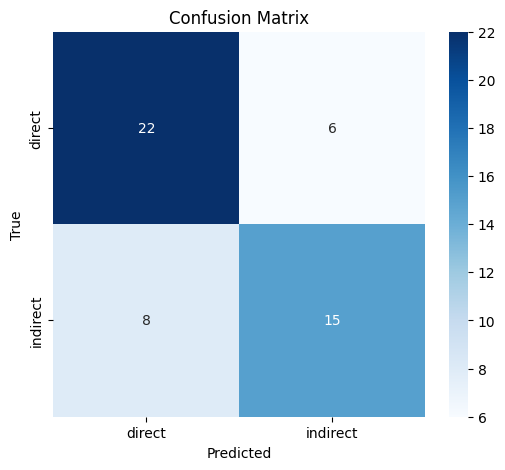

Feature Importances:
head_Angle_filtered: 0.1343
head_Angle: 0.1318
left_ankle_Angle: 0.0551
head_Acceleration: 0.0527
left_ankle_Velocity_normalized: 0.0407
left_ankle_Angle_filtered: 0.0395
right_wrist_Acceleration_normalized: 0.0336
left_wrist_Angle_filtered: 0.0336
left_ankle_Acceleration_normalized: 0.0308
left_wrist_Acceleration: 0.0305
head_Velocity: 0.0301
left_ankle_Acceleration: 0.0296
left_wrist_Angle: 0.0289
right_wrist_Angle: 0.0287
right_ankle_Acceleration_normalized: 0.0255
right_ankle_Acceleration: 0.0237
right_wrist_Angle_filtered: 0.0236
right_ankle_Velocity: 0.0221
left_ankle_Velocity: 0.0211
left_wrist_Acceleration_normalized: 0.0196
right_wrist_Velocity_normalized: 0.0187
right_ankle_Velocity_normalized: 0.0183
head_Velocity_normalized: 0.0183
right_wrist_Velocity: 0.0182
right_wrist_Acceleration: 0.0181
right_ankle_Angle: 0.0166
left_wrist_Velocity: 0.0157
head_Acceleration_normalized: 0.0157
right_ankle_Angle_filtered: 0.0132
left_wrist_Velocity_normalized: 0.011

C:\Users\asus\AppData\Local\Temp\ipykernel_15316\3146091439.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[f[1] for f in sorted_features], y=[f[0] for f in sorted_features], palette="viridis")


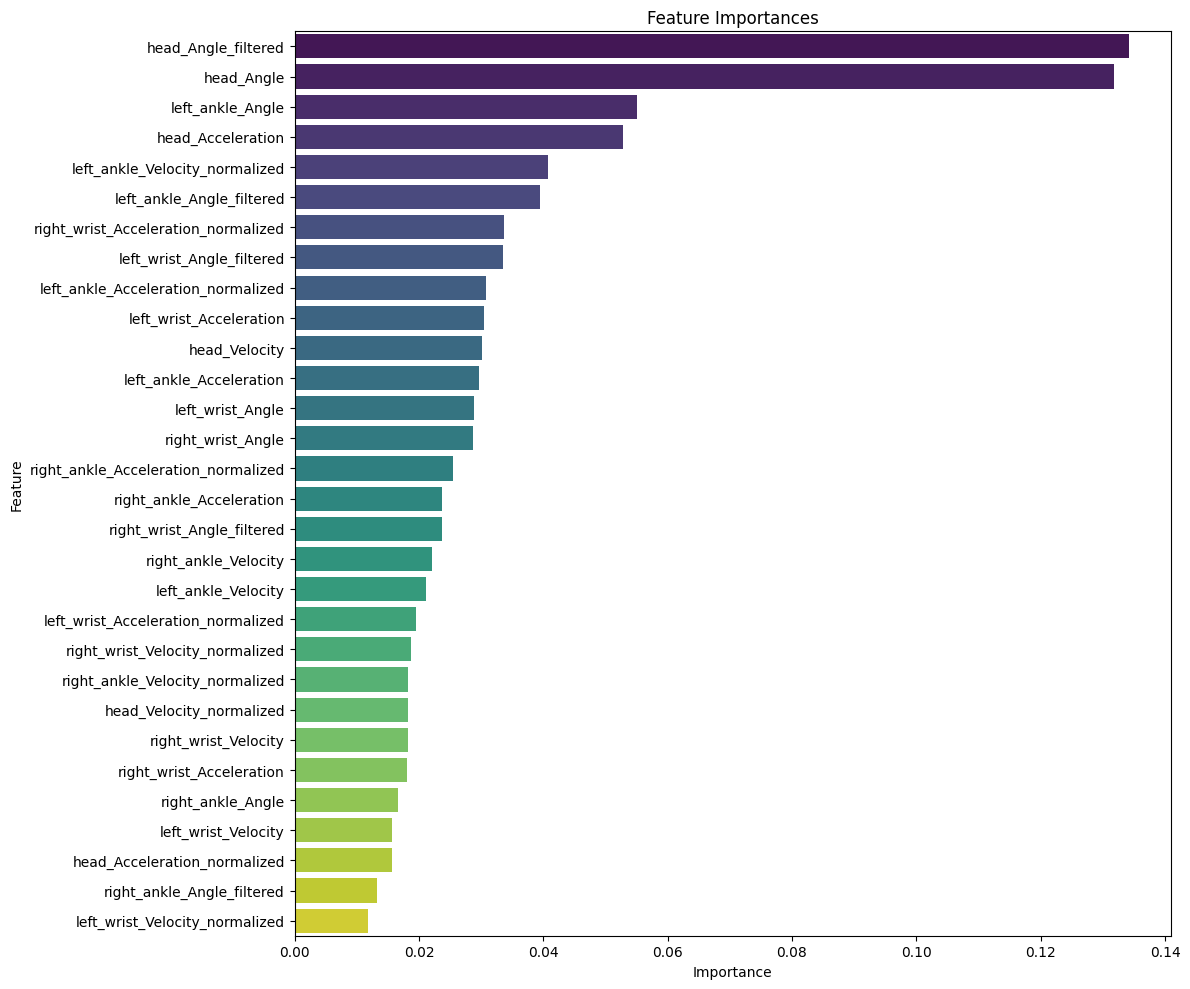

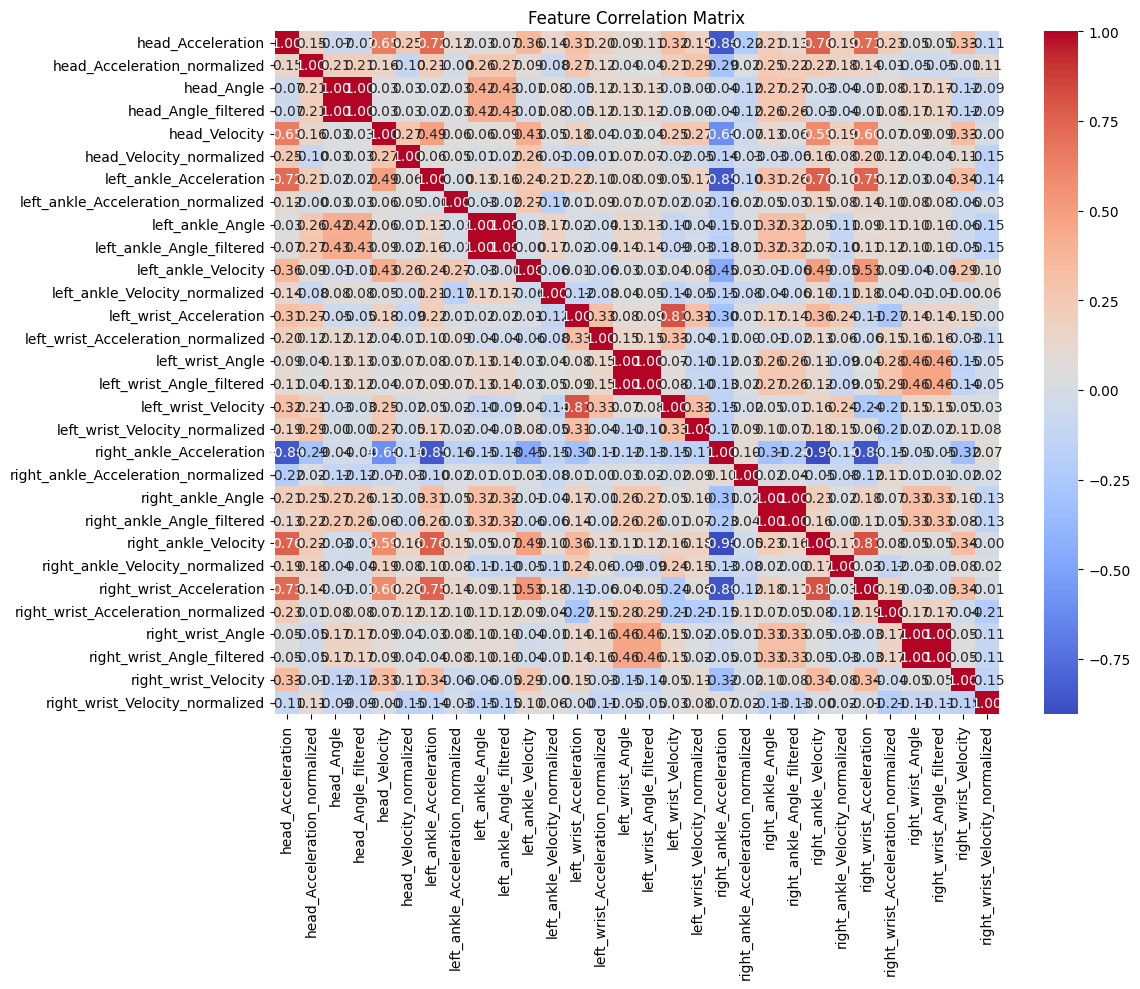

In [116]:
print(classification_report(y_test, y_pred))

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Confusion matrix plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=rf.classes_, yticklabels=rf.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Feature importances
importances = rf.feature_importances_
feature_names = X.columns
feature_importance_dict = dict(zip(feature_names, importances))
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)
print("Feature Importances:")
for feature, importance in sorted_features:
    print(f"{feature}: {importance:.4f}")

# Plot feature importances
plt.figure(figsize=(12, 10))
sns.barplot(x=[f[1] for f in sorted_features], y=[f[0] for f in sorted_features], palette="viridis")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importances")
plt.tight_layout()
plt.show()

# Plot correlation matrix of features with increased figure size for better visibility
plt.figure(figsize=(12, 10))
corr = X.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()

### **Create and Build Model With Sampled Data**

#### Sampling Data

In [129]:
# Separate classes
df_direct = landmark_processed_data[landmark_processed_data['Classification'] == 'direct']
df_indirect = landmark_processed_data[landmark_processed_data['Classification'] == 'indirect']

# Resample to balance classes
df_direct_resampled = resample(df_direct, replace=True, n_samples=len(df_indirect), random_state=42)
df_balanced = pd.concat([df_direct_resampled, df_indirect])

# Shuffle the dataset
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Define features and target for balanced data
X_balanced = df_balanced[X.columns]
y_balanced = df_balanced['Classification']

# Split balanced data
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# Correct scaling process
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # Fit and transform training data
X_test = scaler.transform(X_test)       # Transform test data using the same scaler

#### Build Model

In [130]:
# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict and report
y_pred = rf.predict(X_test)

#### Test Model

              precision    recall  f1-score   support

      direct       0.90      1.00      0.95        18
    indirect       1.00      0.88      0.93        16

    accuracy                           0.94        34
   macro avg       0.95      0.94      0.94        34
weighted avg       0.95      0.94      0.94        34



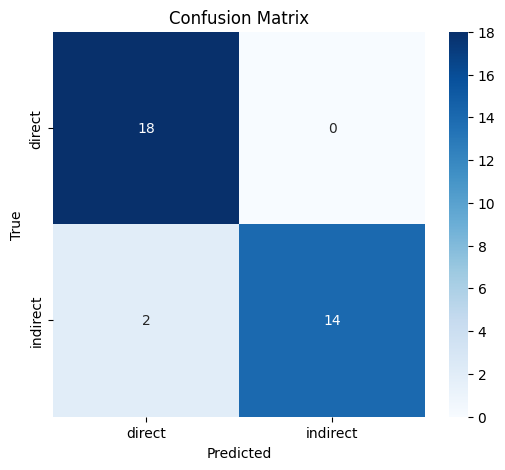

Feature Importances:
head_Angle_filtered: 0.1590
head_Angle: 0.1332
head_Velocity: 0.0573
head_Acceleration: 0.0500
right_wrist_Angle_filtered: 0.0494
left_wrist_Velocity: 0.0416
right_ankle_Acceleration_normalized: 0.0390
left_wrist_Angle_filtered: 0.0340
left_wrist_Angle: 0.0327
right_wrist_Angle: 0.0303
right_ankle_Velocity: 0.0262
right_wrist_Acceleration: 0.0261
right_ankle_Acceleration: 0.0260
left_ankle_Velocity: 0.0257
left_ankle_Angle_filtered: 0.0242
right_ankle_Angle: 0.0238
right_ankle_Angle_filtered: 0.0230
left_ankle_Acceleration: 0.0224
right_wrist_Velocity: 0.0214
left_ankle_Acceleration_normalized: 0.0185
left_ankle_Angle: 0.0170
left_wrist_Acceleration: 0.0165
right_wrist_Acceleration_normalized: 0.0160
left_wrist_Acceleration_normalized: 0.0157
head_Velocity_normalized: 0.0129
left_wrist_Velocity_normalized: 0.0126
right_ankle_Velocity_normalized: 0.0126
left_ankle_Velocity_normalized: 0.0119
right_wrist_Velocity_normalized: 0.0114
head_Acceleration_normalized: 0.009

C:\Users\asus\AppData\Local\Temp\ipykernel_15316\3146091439.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[f[1] for f in sorted_features], y=[f[0] for f in sorted_features], palette="viridis")


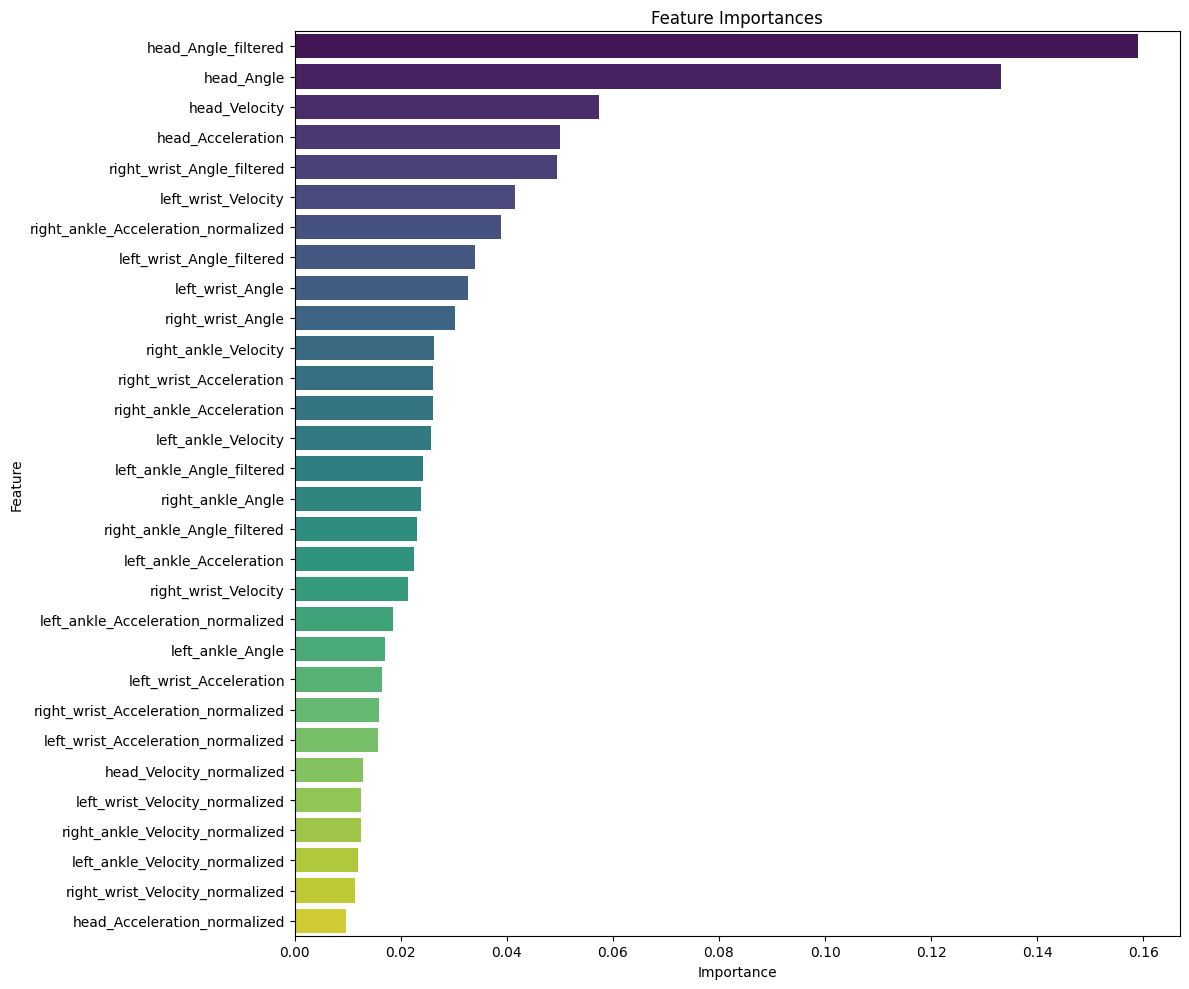

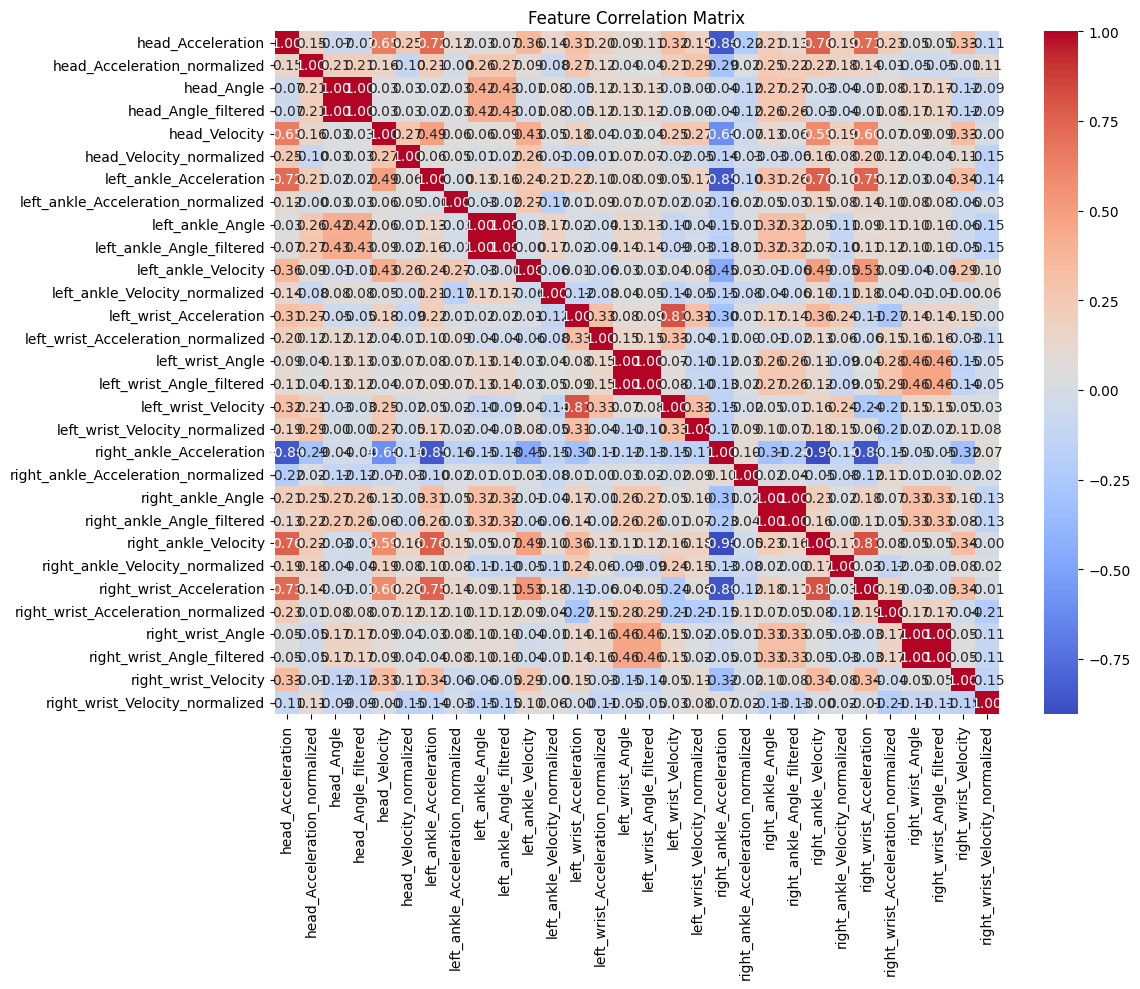

In [131]:
print(classification_report(y_test, y_pred))

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Confusion matrix plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=rf.classes_, yticklabels=rf.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Feature importances
importances = rf.feature_importances_
feature_names = X.columns
feature_importance_dict = dict(zip(feature_names, importances))
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)
print("Feature Importances:")
for feature, importance in sorted_features:
    print(f"{feature}: {importance:.4f}")

# Plot feature importances
plt.figure(figsize=(12, 10))
sns.barplot(x=[f[1] for f in sorted_features], y=[f[0] for f in sorted_features], palette="viridis")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importances")
plt.tight_layout()
plt.show()

# Plot correlation matrix of features with increased figure size for better visibility
plt.figure(figsize=(12, 10))
corr = X.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()

### **Create and Build Model with Hyperparameter Tuning**

#### **With Sampled Data**

##### Get Data

In [135]:
# Separate classes
df_direct = landmark_processed_data[landmark_processed_data['Classification'] == 'direct']
df_indirect = landmark_processed_data[landmark_processed_data['Classification'] == 'indirect']

# Resample to balance classes
df_direct_resampled = resample(df_direct, replace=True, n_samples=len(df_indirect), random_state=42)
df_balanced = pd.concat([df_direct_resampled, df_indirect])

# Shuffle the dataset
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Define features and target for balanced data
X_balanced = df_balanced[X.columns]
y_balanced = df_balanced['Classification']

# Split balanced data
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# Correct scaling process
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # Fit and transform training data
X_test = scaler.transform(X_test)       # Transform test data using the same scaler

##### Build Model

In [136]:
# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform grid search using the balanced and scaled data
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Use the best model
rf = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")

# Predict and report
y_pred = rf.predict(X_test)

Best parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}


##### Test Model 

              precision    recall  f1-score   support

      direct       0.95      1.00      0.97        18
    indirect       1.00      0.94      0.97        16

    accuracy                           0.97        34
   macro avg       0.97      0.97      0.97        34
weighted avg       0.97      0.97      0.97        34



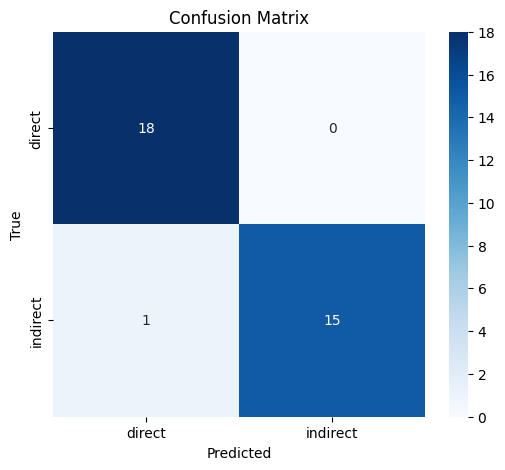

Feature Importances:
head_Angle_filtered: 0.1571
head_Angle: 0.1430
head_Velocity: 0.0585
head_Acceleration: 0.0551
right_wrist_Angle_filtered: 0.0527
right_ankle_Acceleration_normalized: 0.0439
left_wrist_Velocity: 0.0354
left_wrist_Angle_filtered: 0.0323
right_wrist_Angle: 0.0317
left_ankle_Velocity: 0.0305
left_wrist_Angle: 0.0260
right_wrist_Acceleration: 0.0258
left_ankle_Angle_filtered: 0.0257
right_ankle_Angle: 0.0236
right_ankle_Angle_filtered: 0.0226
left_ankle_Acceleration_normalized: 0.0220
right_wrist_Velocity: 0.0204
right_ankle_Velocity: 0.0197
left_ankle_Acceleration: 0.0195
left_wrist_Acceleration: 0.0191
right_ankle_Acceleration: 0.0189
left_wrist_Acceleration_normalized: 0.0178
right_ankle_Velocity_normalized: 0.0171
right_wrist_Acceleration_normalized: 0.0160
left_ankle_Angle: 0.0150
left_ankle_Velocity_normalized: 0.0119
left_wrist_Velocity_normalized: 0.0115
right_wrist_Velocity_normalized: 0.0105
head_Velocity_normalized: 0.0089
head_Acceleration_normalized: 0.007

C:\Users\asus\AppData\Local\Temp\ipykernel_15316\1592402509.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[f[1] for f in sorted_features], y=[f[0] for f in sorted_features], palette="viridis")


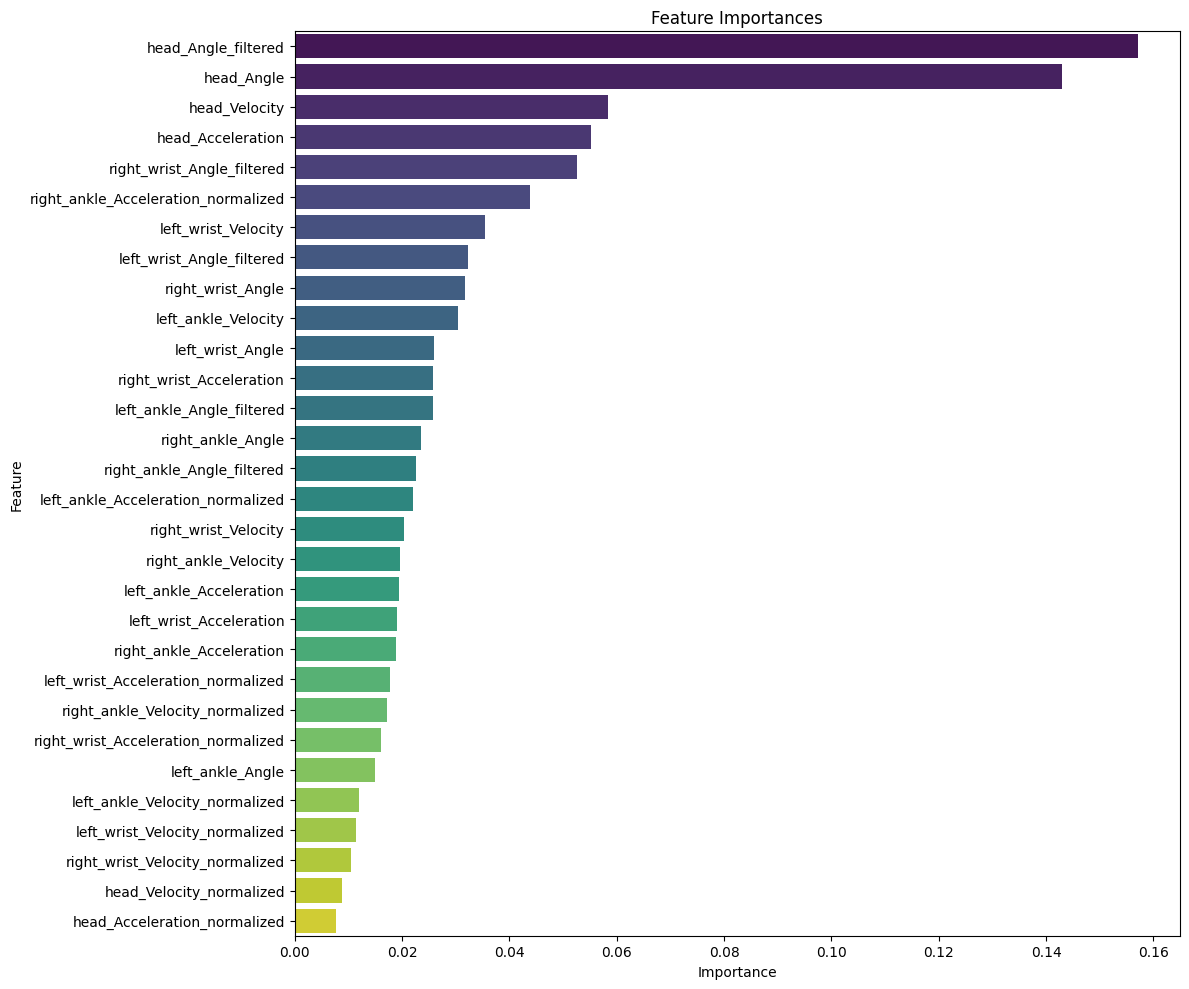

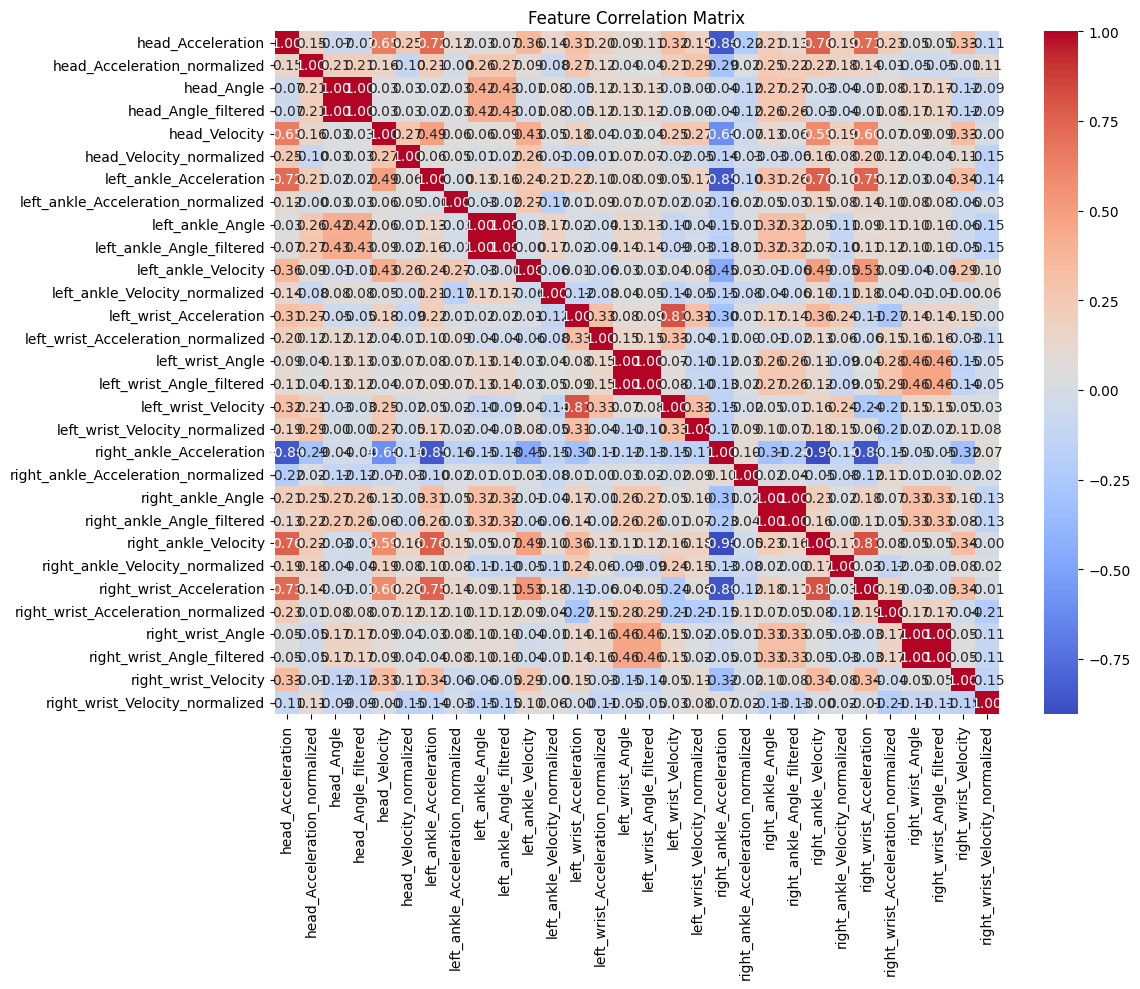

In [137]:
print(classification_report(y_test, y_pred))

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Confusion matrix plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=rf.classes_, yticklabels=rf.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Feature importances
importances = rf.feature_importances_
feature_names = X.columns
feature_importance_dict = dict(zip(feature_names, importances))
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)
print("Feature Importances:")
for feature, importance in sorted_features:
    print(f"{feature}: {importance:.4f}")

# Plot feature importances
plt.figure(figsize=(12, 10))
sns.barplot(x=[f[1] for f in sorted_features], y=[f[0] for f in sorted_features], palette="viridis")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importances")
plt.tight_layout()
plt.show()

# Plot correlation matrix of features
plt.figure(figsize=(12, 10))
corr = X.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()

#### **With Unsampled Data**

##### Get Data

In [138]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

##### Build Model

In [139]:
# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform grid search using the balanced and scaled data
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Use the best model
rf = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")

# Predict and report
y_pred = rf.predict(X_test)

Best parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}


##### Test Model 

              precision    recall  f1-score   support

      direct       0.70      0.68      0.69        28
    indirect       0.62      0.65      0.64        23

    accuracy                           0.67        51
   macro avg       0.66      0.67      0.66        51
weighted avg       0.67      0.67      0.67        51



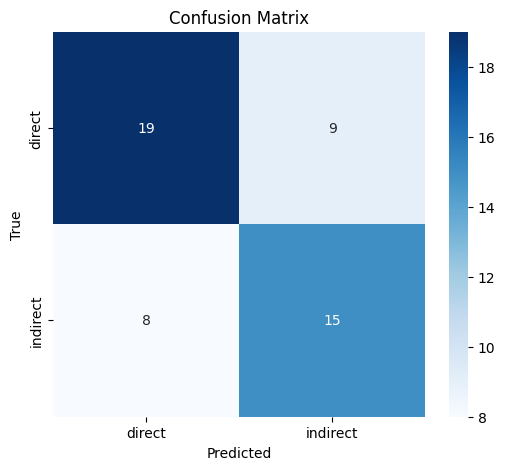

Feature Importances:
head_Angle: 0.1630
head_Angle_filtered: 0.1624
head_Acceleration: 0.0740
left_ankle_Angle: 0.0539
left_ankle_Angle_filtered: 0.0424
left_ankle_Velocity_normalized: 0.0392
left_ankle_Acceleration: 0.0348
head_Velocity: 0.0317
left_wrist_Acceleration: 0.0300
right_wrist_Acceleration_normalized: 0.0291
left_wrist_Angle_filtered: 0.0266
left_wrist_Angle: 0.0252
left_ankle_Acceleration_normalized: 0.0247
right_wrist_Angle_filtered: 0.0245
left_ankle_Velocity: 0.0231
right_ankle_Acceleration: 0.0224
right_wrist_Angle: 0.0213
right_ankle_Acceleration_normalized: 0.0182
left_wrist_Acceleration_normalized: 0.0160
right_ankle_Angle_filtered: 0.0152
right_wrist_Velocity_normalized: 0.0148
right_ankle_Angle: 0.0142
right_wrist_Acceleration: 0.0136
right_wrist_Velocity: 0.0136
head_Acceleration_normalized: 0.0133
right_ankle_Velocity_normalized: 0.0132
right_ankle_Velocity: 0.0120
head_Velocity_normalized: 0.0099
left_wrist_Velocity_normalized: 0.0093
left_wrist_Velocity: 0.008

C:\Users\asus\AppData\Local\Temp\ipykernel_15316\1592402509.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[f[1] for f in sorted_features], y=[f[0] for f in sorted_features], palette="viridis")


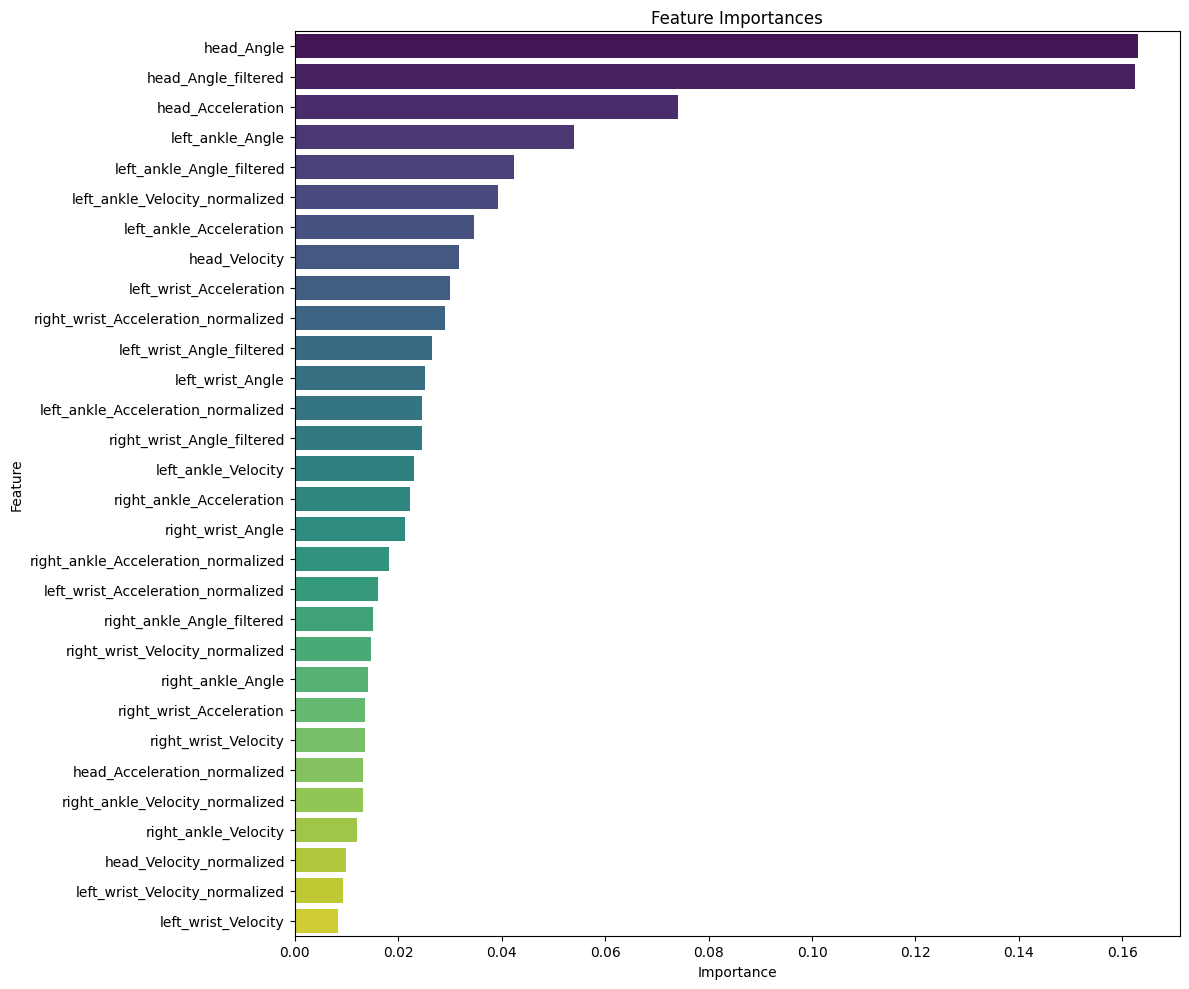

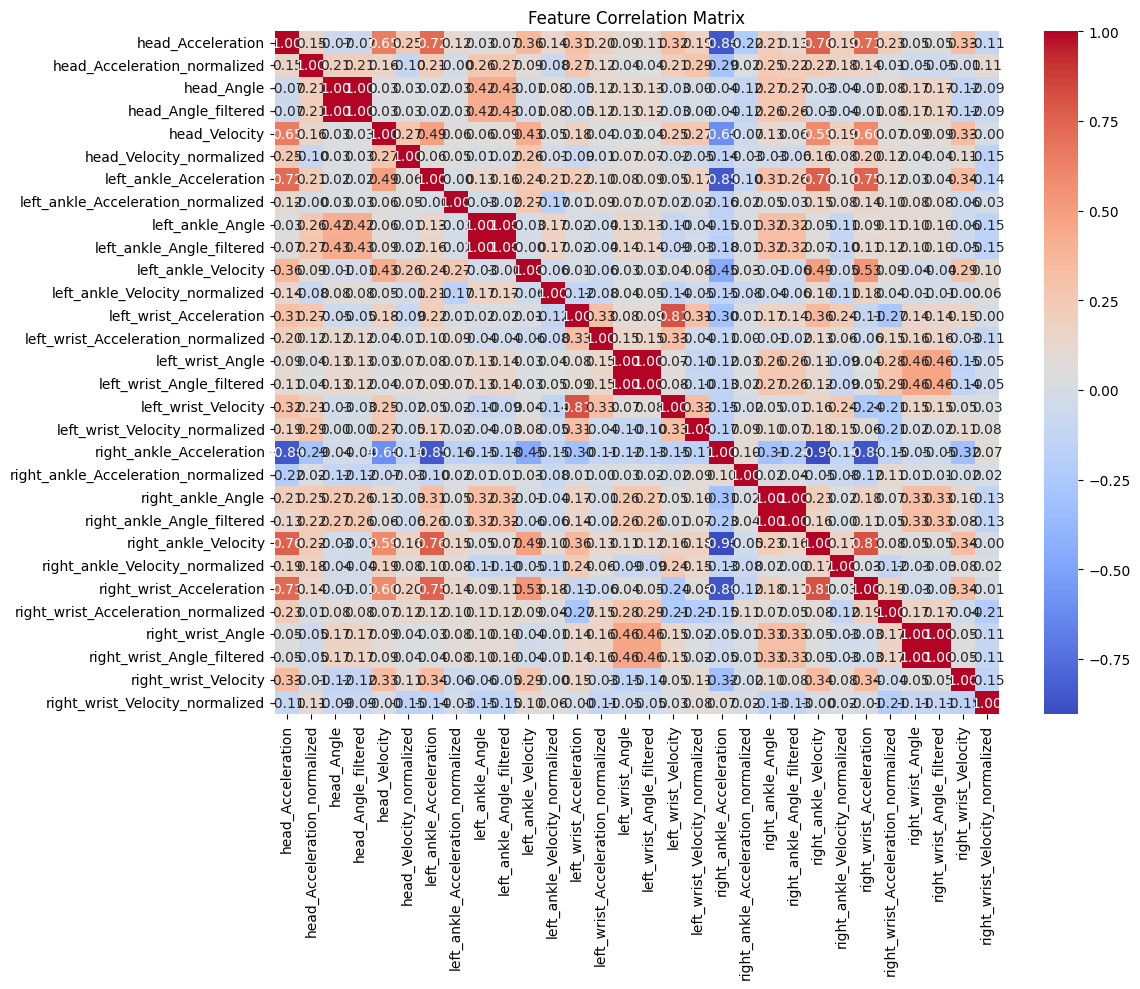

In [140]:
print(classification_report(y_test, y_pred))

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Confusion matrix plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=rf.classes_, yticklabels=rf.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Feature importances
importances = rf.feature_importances_
feature_names = X.columns
feature_importance_dict = dict(zip(feature_names, importances))
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)
print("Feature Importances:")
for feature, importance in sorted_features:
    print(f"{feature}: {importance:.4f}")

# Plot feature importances
plt.figure(figsize=(12, 10))
sns.barplot(x=[f[1] for f in sorted_features], y=[f[0] for f in sorted_features], palette="viridis")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importances")
plt.tight_layout()
plt.show()

# Plot correlation matrix of features
plt.figure(figsize=(12, 10))
corr = X.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()

### **Try XGBoost Model**

#### **With Sampled Data**

##### Get Data

In [143]:
# Separate classes
df_direct = landmark_processed_data[landmark_processed_data['Classification'] == 'direct']
df_indirect = landmark_processed_data[landmark_processed_data['Classification'] == 'indirect']

# Resample to balance classes
df_direct_resampled = resample(df_direct, replace=True, n_samples=len(df_indirect), random_state=42)
df_balanced = pd.concat([df_direct_resampled, df_indirect])

# Shuffle the dataset
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Define features and target for balanced data
X_balanced = df_balanced[X.columns]
y_balanced = df_balanced['Classification']

# Split balanced data
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# Correct scaling process
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # Fit and transform training data
X_test = scaler.transform(X_test)       # Transform test data using the same scaler

##### Build and Test Model

              precision    recall  f1-score   support

      direct       0.82      1.00      0.90        18
    indirect       1.00      0.75      0.86        16

    accuracy                           0.88        34
   macro avg       0.91      0.88      0.88        34
weighted avg       0.90      0.88      0.88        34



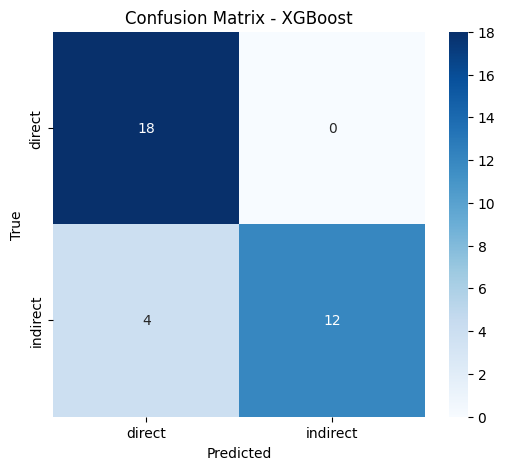

Feature Importances (XGBoost):
head_Angle: 0.2146
right_wrist_Angle: 0.0817
right_ankle_Acceleration: 0.0758
right_wrist_Acceleration_normalized: 0.0628
head_Velocity: 0.0483
right_wrist_Acceleration: 0.0480
right_wrist_Velocity: 0.0440
left_ankle_Velocity: 0.0394
head_Acceleration: 0.0387
left_ankle_Angle_filtered: 0.0367
head_Acceleration_normalized: 0.0297
left_ankle_Angle: 0.0279
right_ankle_Velocity: 0.0261
left_ankle_Velocity_normalized: 0.0236
right_ankle_Acceleration_normalized: 0.0234
left_ankle_Acceleration_normalized: 0.0228
right_ankle_Velocity_normalized: 0.0203
left_wrist_Acceleration: 0.0193
right_ankle_Angle: 0.0182
left_wrist_Velocity_normalized: 0.0169
left_ankle_Acceleration: 0.0160
left_wrist_Acceleration_normalized: 0.0156
right_wrist_Angle_filtered: 0.0139
head_Velocity_normalized: 0.0137
right_wrist_Velocity_normalized: 0.0121
left_wrist_Angle: 0.0106
head_Angle_filtered: 0.0000
left_wrist_Angle_filtered: 0.0000
left_wrist_Velocity: 0.0000
right_ankle_Angle_filte

C:\Users\asus\AppData\Local\Temp\ipykernel_15316\3553490379.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[f[1] for f in sorted_features], y=[f[0] for f in sorted_features], palette="viridis")


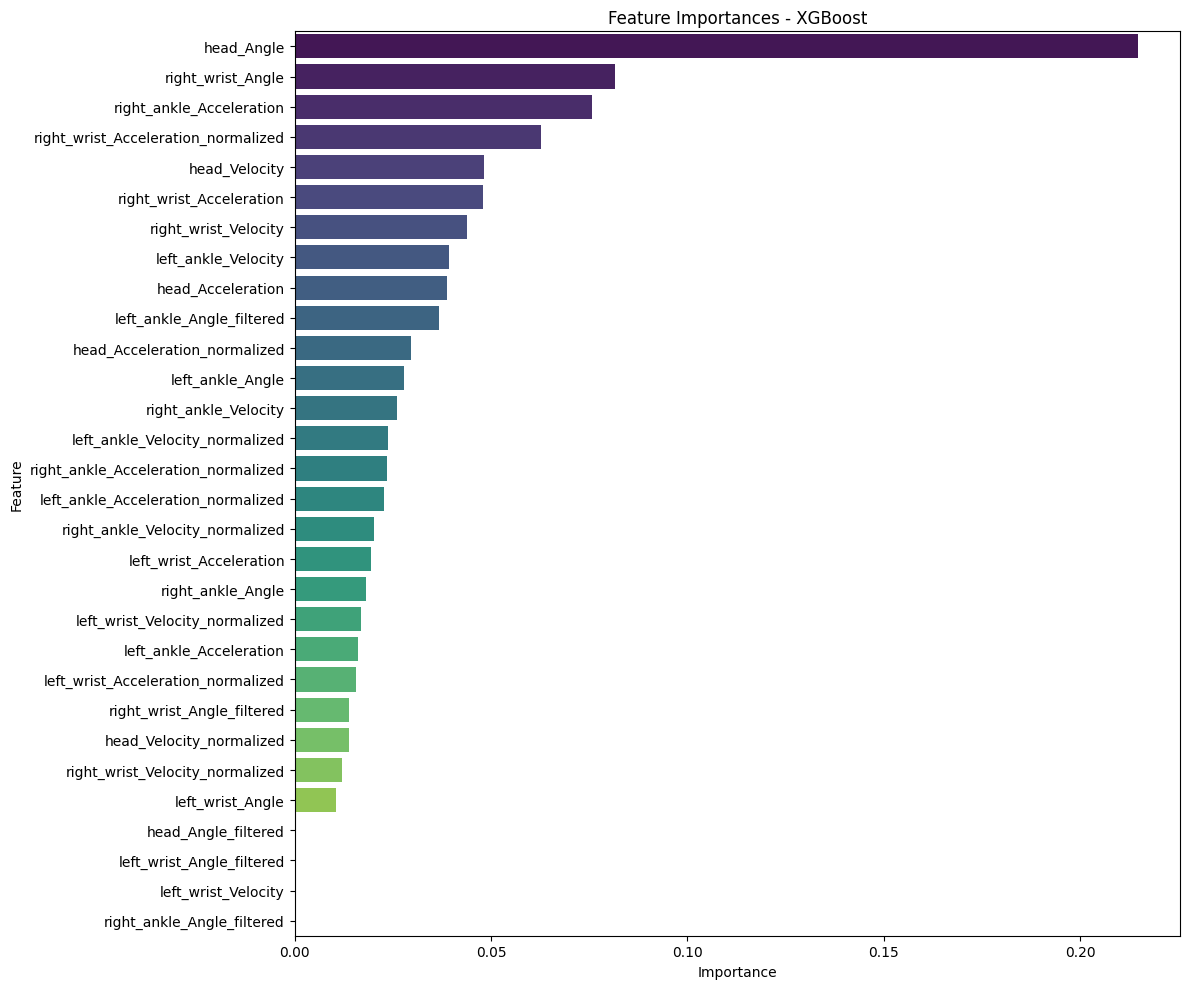

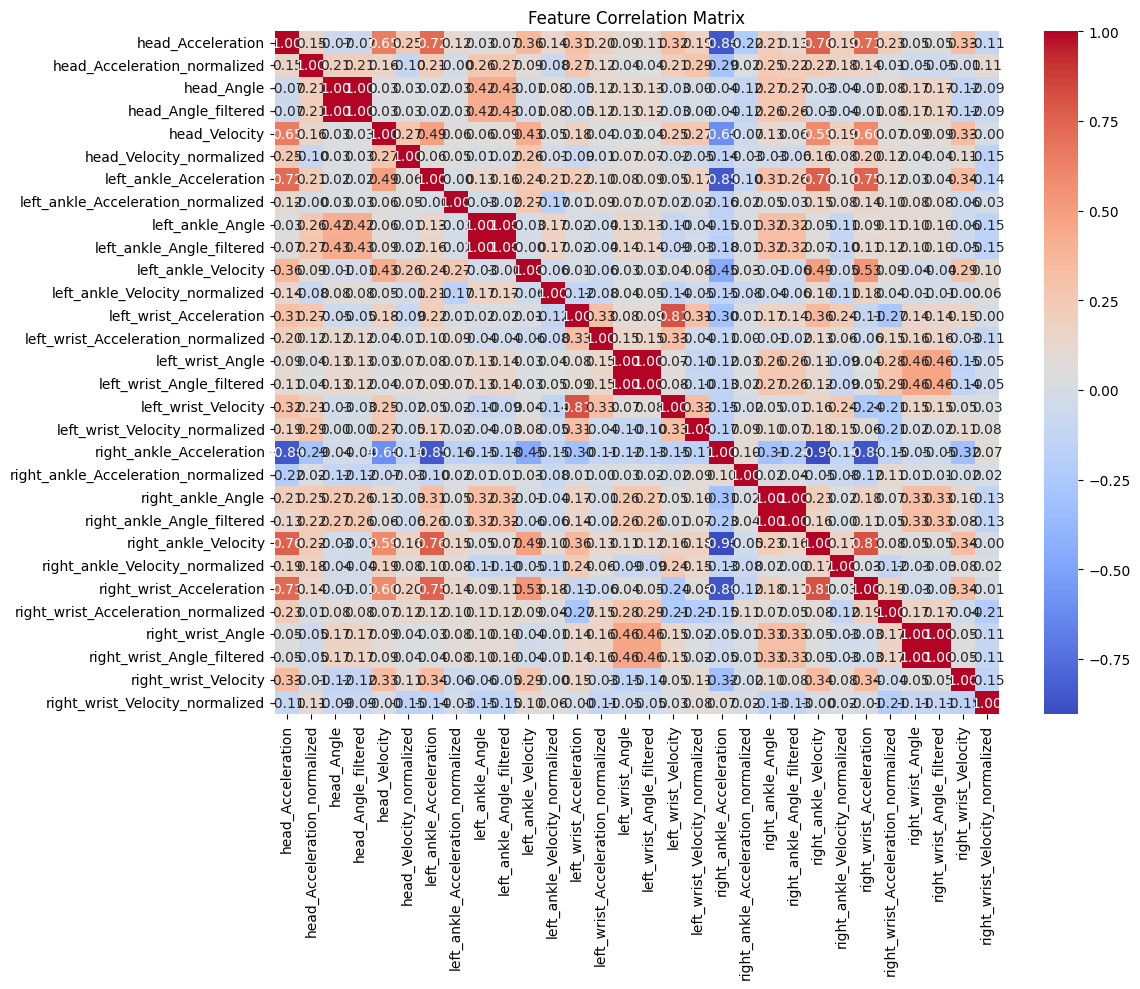

In [144]:
# Encode target variable
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Train XGBoost
xgb = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
xgb.fit(X_train, y_train_encoded)

# Predict and evaluate
y_pred_encoded = xgb.predict(X_test)
y_pred = label_encoder.inverse_transform(y_pred_encoded)

print(classification_report(y_test, y_pred))

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Confusion matrix plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - XGBoost')
plt.show()

# Feature importances
importances = xgb.feature_importances_
feature_names = X.columns
feature_importance_dict = dict(zip(feature_names, importances))
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)
print("Feature Importances (XGBoost):")
for feature, importance in sorted_features:
    print(f"{feature}: {importance:.4f}")

# Plot feature importances
plt.figure(figsize=(12, 10))
sns.barplot(x=[f[1] for f in sorted_features], y=[f[0] for f in sorted_features], palette="viridis")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importances - XGBoost")
plt.tight_layout()
plt.show()

# Plot correlation matrix of features
plt.figure(figsize=(12, 10))
corr = X.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()

#### **With Unsampled Data**

##### Get Data

In [145]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

##### Build and Test Model

              precision    recall  f1-score   support

      direct       0.93      0.68      0.79        19
    indirect       0.70      0.93      0.80        15

    accuracy                           0.79        34
   macro avg       0.81      0.81      0.79        34
weighted avg       0.83      0.79      0.79        34



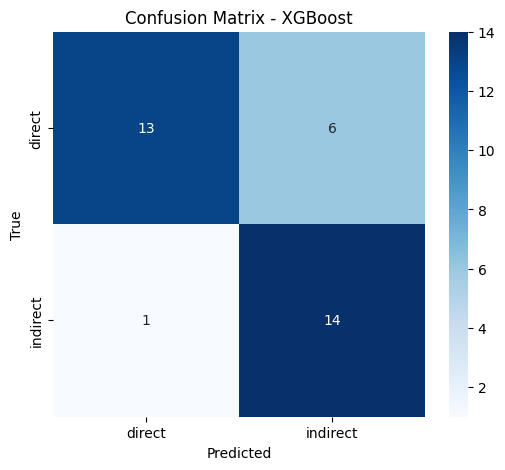

Feature Importances (XGBoost):
head_Angle: 0.1477
right_wrist_Acceleration_normalized: 0.0714
left_wrist_Angle: 0.0629
head_Acceleration: 0.0581
left_wrist_Angle_filtered: 0.0570
head_Acceleration_normalized: 0.0515
left_wrist_Velocity: 0.0504
right_wrist_Velocity: 0.0469
left_ankle_Velocity_normalized: 0.0385
left_ankle_Angle: 0.0323
right_ankle_Acceleration: 0.0297
right_ankle_Angle: 0.0293
left_wrist_Acceleration_normalized: 0.0254
right_wrist_Angle: 0.0252
left_ankle_Acceleration_normalized: 0.0251
left_ankle_Acceleration: 0.0222
head_Velocity_normalized: 0.0222
right_wrist_Angle_filtered: 0.0219
left_ankle_Angle_filtered: 0.0206
head_Velocity: 0.0204
right_ankle_Velocity: 0.0199
right_wrist_Acceleration: 0.0193
left_ankle_Velocity: 0.0179
right_ankle_Acceleration_normalized: 0.0165
left_wrist_Acceleration: 0.0145
left_wrist_Velocity_normalized: 0.0133
head_Angle_filtered: 0.0115
right_wrist_Velocity_normalized: 0.0110
right_ankle_Velocity_normalized: 0.0102
right_ankle_Angle_filte

C:\Users\asus\AppData\Local\Temp\ipykernel_15316\3553490379.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[f[1] for f in sorted_features], y=[f[0] for f in sorted_features], palette="viridis")


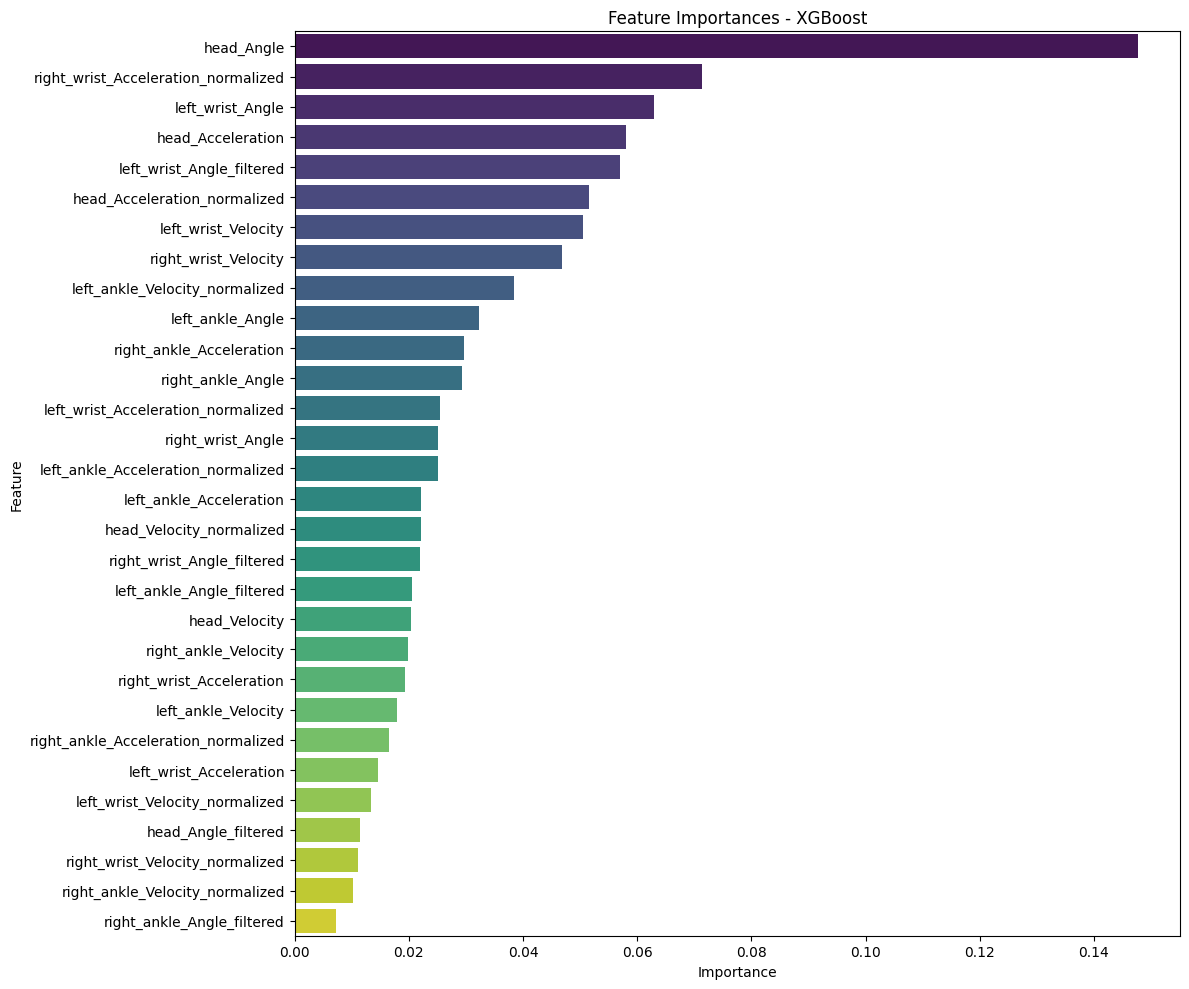

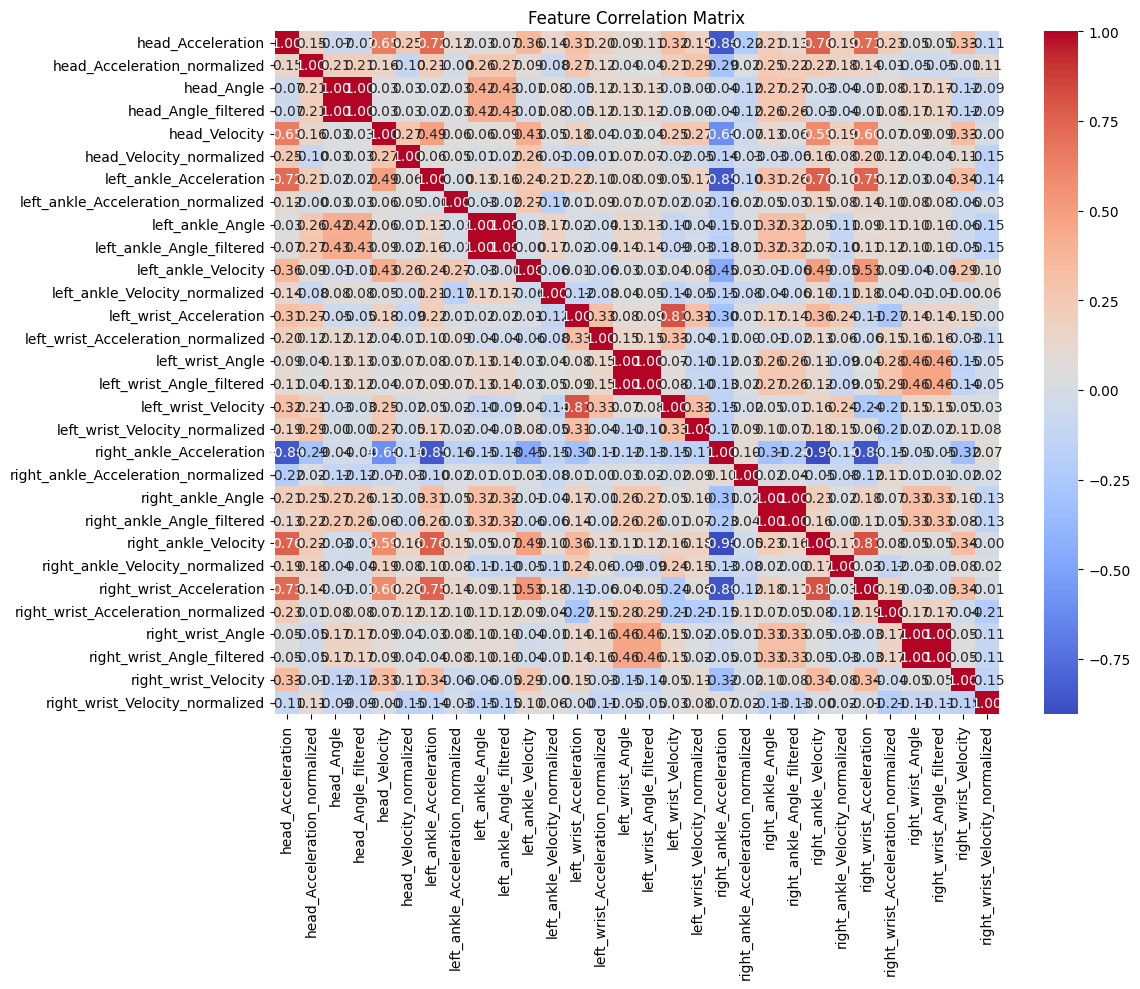

In [146]:
# Encode target variable
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Train XGBoost
xgb = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
xgb.fit(X_train, y_train_encoded)

# Predict and evaluate
y_pred_encoded = xgb.predict(X_test)
y_pred = label_encoder.inverse_transform(y_pred_encoded)

print(classification_report(y_test, y_pred))

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Confusion matrix plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - XGBoost')
plt.show()

# Feature importances
importances = xgb.feature_importances_
feature_names = X.columns
feature_importance_dict = dict(zip(feature_names, importances))
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)
print("Feature Importances (XGBoost):")
for feature, importance in sorted_features:
    print(f"{feature}: {importance:.4f}")

# Plot feature importances
plt.figure(figsize=(12, 10))
sns.barplot(x=[f[1] for f in sorted_features], y=[f[0] for f in sorted_features], palette="viridis")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importances - XGBoost")
plt.tight_layout()
plt.show()

# Plot correlation matrix of features
plt.figure(figsize=(12, 10))
corr = X.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()